In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, validation_curve, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.neighbors import KNeighborsClassifier

my_random_state = 318

import warnings
warnings.filterwarnings(action='once')


import time
num_classifiers = 5
train_time = np.zeros(num_classifiers)
learningcurve_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)
best_test_accuracy = np.zeros(num_classifiers)
best_train_accuracy = np.zeros(num_classifiers)

# 0. Import Data & Preprocessing (choose either cell to run, don't run both)

In [21]:
###### E-coli 
### http://archive.ics.uci.edu/ml/datasets/Ecoli
# data = pd.read_csv('datafiles/ecoli.csv')))  # very unbalanced
# class_names = np.array(['cp', 'im', 'imL', 'imS', 'imU','om','omL','pp'])
data = pd.read_csv('datafiles/ecoli-balance.csv') # balanced: merged sub-species of E-coli
class_names = np.array(['cp', 'im', 'om','pp'])
y_data = data.Y
x_data = data.loc[:,'X1':'X7']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.7, random_state=my_random_state, shuffle=True)

In [23]:
##### Adult Income
### http://archive.ics.uci.edu/ml/datasets/Adult
data = pd.read_csv('datafiles/adult.csv')
data

y_data_raw = data.income

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_data_raw.values.tolist())
y_data = le.transform(y_data_raw)


x_data_raw = data.loc[:,'age':'native-country']

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(x_data_raw.values.tolist())
x_data = enc.transform(x_data_raw)

# temp = enc.inverse_transform(x_data)


x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.7, random_state=my_random_state, shuffle=True)

# 1. Decision Trees

In [25]:
dt = tree.DecisionTreeClassifier(random_state=my_random_state)

## 1.1. validation curve


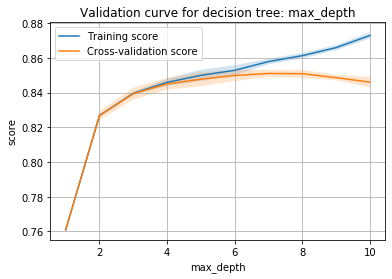

Best cross-validation result (0.8510) obtained for max_depth=7


In [26]:
# dt = tree.DecisionTreeClassifier(random_state=my_random_state, splitter = 'best', criterion = 'entropy')
depth_range = np.arange(10) + 1
train_scores, test_scores = validation_curve(dt, x_train, y_train, param_name="max_depth", param_range=depth_range, cv=5)

plt.figure()
# plt.xticks(depth_range)

train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(depth_range, train_scores_avg, label='Training score')
plt.plot(depth_range, test_scores_avg, label='Cross-validation score')
plt.fill_between(depth_range, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(depth_range, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for decision tree: max_depth')
plt.xlabel('max_depth')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/dt_validation_curve.png')
plt.show()

i = np.argmax(test_scores_avg)
print("Best cross-validation result ({0:.4f}) obtained for max_depth={1}".format(test_scores_avg[i], depth_range[i]))

# Best cross-validation result (0.8510) obtained for max_depth=7

## 1.2. hyperparameter tuning


In [27]:
parameters = {'max_depth':depth_range, 'criterion': ['gini','entropy']}#, 'splitter': ['best','random']}
grid_dt = GridSearchCV(dt, parameters)

tic = time.perf_counter_ns() 
grid_dt.fit(x_train, y_train)
toc = time.perf_counter_ns() 
train_time[0] = toc-tic
print(f"training time {toc - tic} nanoseconds")
print()

print("best parameters & score from GridSearchCV: ")
print(grid_dt.best_params_)
print(grid_dt.best_score_)
print()

# training time 4957920200 nanoseconds

# best parameters & score from GridSearchCV: 
# {'criterion': 'entropy', 'max_depth': 8}
# 0.8516148135685976


training time 4957920200 nanoseconds

best parameters & score from GridSearchCV: 
{'criterion': 'entropy', 'max_depth': 8}
0.8516148135685976



## 1.3 learning curve


learning curve time 55.3736 seconds



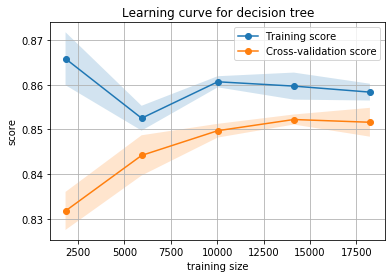

In [28]:
trainsizes = np.linspace(0.1, 1.0, 5)
tic = time.perf_counter() 
train_sizes, train_scores, test_scores = learning_curve(grid_dt, x_train, y_train, train_sizes=trainsizes,
                                                        random_state=my_random_state, cv=5)
toc = time.perf_counter() 
learningcurve_time[0] = toc-tic
print(f"learning curve time {toc - tic:0.4f} seconds") 
print()

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_avg, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_avg, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std, alpha=0.2)

plt.title('Learning curve for decision tree')
plt.xlabel('training size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/dt_learning_curve.png') 
plt.show()

# learning curve time 55.3736 seconds


## 1.4 prediction & confusion matrix

testing time 1868300 nanoseconds

Prediction accuracy on test set: 
0.8544375063977889
Prediction accuracy on train set: 
0.8578887328887329


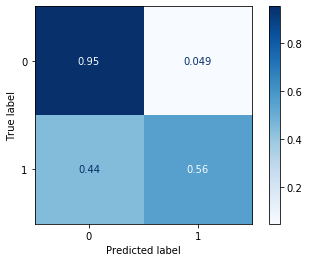

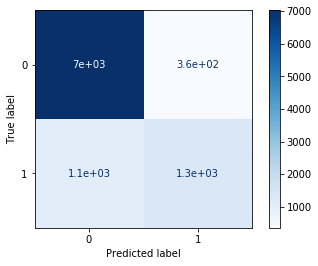

In [29]:

tic = time.perf_counter_ns() 
y_test_dt = grid_dt.predict(x_test)
toc = time.perf_counter_ns() 
test_time[0] = toc-tic
print(f"testing time {toc - tic} nanoseconds")
print()
print("Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_dt))
best_test_accuracy[0] = accuracy_score(y_test,y_test_dt)

y_train_dt = grid_dt.predict(x_train)
print("Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_dt))
best_train_accuracy[0] = accuracy_score(y_train,y_train_dt)

# testing time 1868300  nanoseconds

# Prediction accuracy on test set: 
# 0.8544375063977889
# Prediction accuracy on train set: 
# 0.8578887328887329

plot_confusion_matrix(grid_dt, x_test, y_test,normalize='true',cmap=plt.cm.Blues)
plt.savefig('figures/dt_confusion_matrix_normalized.png') 
plt.show()

plot_confusion_matrix(grid_dt, x_test, y_test,cmap=plt.cm.Blues)
plt.savefig('figures/dt_confusion_matrix.png') 
plt.show()

In [30]:

train_time,learningcurve_time ,test_time ,best_test_accuracy , best_train_accuracy

(array([4.9579202e+09, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00]),
 array([55.3735978,  0.       ,  0.       ,  0.       ,  0.       ]),
 array([1868300.,       0.,       0.,       0.,       0.]),
 array([0.85443751, 0.        , 0.        , 0.        , 0.        ]),
 array([0.85788873, 0.        , 0.        , 0.        , 0.        ]))

# 2. Neural Networks

In [31]:
nn = MLPClassifier(random_state=my_random_state)

In [32]:
nn = MLPClassifier(random_state=my_random_state, max_iter=500, hidden_layer_sizes = (20,20,20))
nn.fit(x_train,y_train)
y_train_nn = nn.predict(x_train)
print("Prediction accuracy: ")
print(accuracy_score(y_train,y_train_nn))
print()
y_test_nn = nn.predict(x_test)
print("Prediction accuracy: ")
print(accuracy_score(y_test,y_test_nn))
nn.n_layers_

#### default NN:
# Prediction accuracy: 
# 0.8045366795366795

# Prediction accuracy: 
# 0.7981369638652882

Prediction accuracy: 
0.8045366795366795

Prediction accuracy: 
0.7981369638652882


5

## 2.1 validation curve

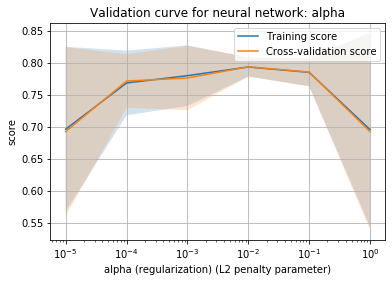

In [101]:
# alpha
alpha_range = np.logspace(-5, 0, 6)
train_scores, test_scores = validation_curve(nn, x_train, y_train, param_name="alpha", param_range=alpha_range, cv=5)

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.semilogx(alpha_range, train_scores_avg, label='Training score')
plt.semilogx(alpha_range, test_scores_avg, label='Cross-validation score')
plt.fill_between(alpha_range, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(alpha_range, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for neural network: alpha')
plt.xlabel('alpha (regularization) (L2 penalty parameter)')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/nn_validation_curve_alpha.png')
plt.show()

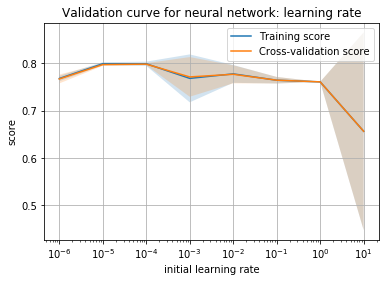

In [100]:
# learning rate
learningrate_range = np.logspace(-6, 1, 8)
train_scores, test_scores = validation_curve(nn, x_train, y_train, param_name="learning_rate_init", param_range=learningrate_range, cv=5)

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.semilogx(learningrate_range, train_scores_avg, label='Training score')
plt.semilogx(learningrate_range, test_scores_avg, label='Cross-validation score')
plt.fill_between(learningrate_range, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(learningrate_range, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for neural network: learning rate')
plt.xlabel('initial learning rate')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/nn_validation_curve_learningrate.png')
plt.show()

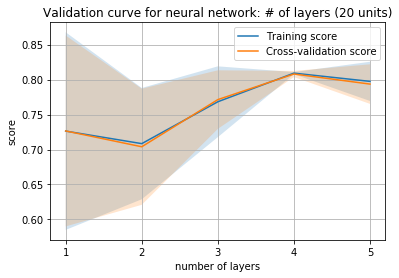

In [97]:
# number of layers
# hiddenlayersizes_range = [(10,),(10,20),(10,10,10),(10,10,10,10),(10,10,10,10,10)]
hiddenlayersizes_range = [(20,),(20,20),(20,20,20),(20,20,20,20),(20,20,20,20,20)]
train_scores, test_scores = validation_curve(nn, x_train, y_train, param_name="hidden_layer_sizes", 
                                             param_range=hiddenlayersizes_range, cv=5)
hiddenlayersizes_xaxis = [1, 2, 3, 4,5]

plt.figure()
plt.xticks(hiddenlayersizes_xaxis)

train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(hiddenlayersizes_xaxis, train_scores_avg, label='Training score')
plt.plot(hiddenlayersizes_xaxis, test_scores_avg, label='Cross-validation score')
plt.fill_between(hiddenlayersizes_xaxis, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(hiddenlayersizes_xaxis, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for neural network: # of layers (20 units)')
plt.xlabel('number of layers')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/nn_validation_curve_numlayers_20.png')
plt.show()


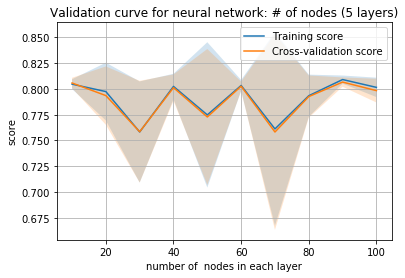

In [102]:
# number of  nodes in each layer\
hiddenlayersizes_xaxis = 10*(np.arange(10)+1)
hiddenlayersizes_range = []
for x in hiddenlayersizes_xaxis:
    hiddenlayersizes_range.append((x,x,x,x,x))

train_scores, test_scores = validation_curve(nn, x_train, y_train, param_name="hidden_layer_sizes", 
                                             param_range=hiddenlayersizes_range, cv=5)

plt.figure()
# plt.xticks(hiddenlayersizes_xaxis)

train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(hiddenlayersizes_xaxis, train_scores_avg, label='Training score')
plt.plot(hiddenlayersizes_xaxis, test_scores_avg, label='Cross-validation score')
plt.fill_between(hiddenlayersizes_xaxis, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(hiddenlayersizes_xaxis, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for neural network: # of nodes (5 layers)')
plt.xlabel('number of  nodes in each layer')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/nn_validation_curve_numnodes_5.png')
plt.show()

## 1.2 hyperparameter tuning

In [37]:
# nn3layer = MLPClassifier(random_state=my_random_state, hidden_layer_sizes = (20,20,20))
parameters = {'alpha':alpha_range, 'learning_rate_init': learningrate_range}
grid_nn = GridSearchCV(nn, parameters)

tic = time.perf_counter_ns() 
grid_nn.fit(x_train, y_train)
toc = time.perf_counter_ns() 
train_time[1] = toc-tic
print(f"training time {toc - tic} nanoseconds")
print()

print("best parameters & score from GridSearchCV: ")
print(grid_nn.best_params_)
print(grid_nn.best_score_)
print()

# training time 563516327800 nanoseconds

# best parameters & score from GridSearchCV: 
# {'alpha': 0.001, 'learning_rate_init': 0.0001}
# 0.8036593688850229



training time 563516327800 nanoseconds

best parameters & score from GridSearchCV: 
{'alpha': 0.001, 'learning_rate_init': 0.0001}
0.8036593688850229



In [96]:
grid_nn.best_estimator_


MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
              learning_rate_init=0.0001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=318, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

## 1.3 learning curve (takes a long time to run)

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  %

C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Xiaosi Gao\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  %

learning curve time 9772.1824 seconds



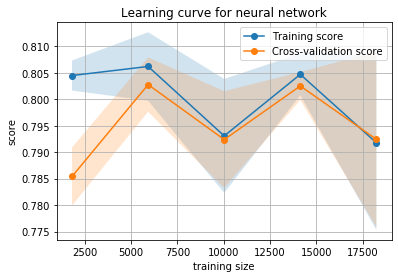

In [38]:
trainsizes = np.linspace(0.1, 1.0, 5)
tic = time.perf_counter() 
train_sizes, train_scores, test_scores = learning_curve(grid_nn, x_train, y_train, train_sizes=trainsizes, 
                                                        random_state=my_random_state, cv=5)
toc = time.perf_counter() 
learningcurve_time[1] = toc-tic
print(f"learning curve time {toc - tic:0.4f} seconds") 
print()


plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_avg, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_avg, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std, alpha=0.2)

plt.title('Learning curve for neural network')
plt.xlabel('training size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/nn_learning_curve.png') 
plt.show()

# learning curve time 9772.1824 seconds


## 1.4 prediction & confusion matrix

testing time 16846400 nanoseconds

Prediction accuracy on test set: 
0.7967038591462791
Prediction accuracy on train set: 
0.7969462969462969


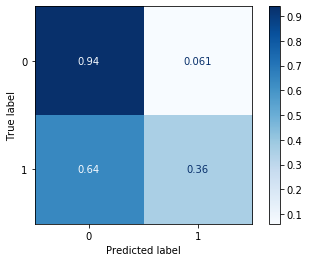

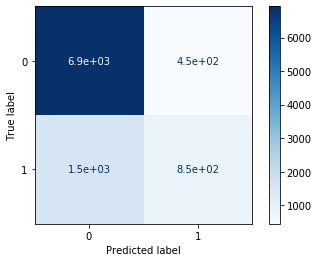

In [39]:
tic = time.perf_counter_ns() 
y_test_nn = grid_nn.predict(x_test)
toc = time.perf_counter_ns() 
test_time[1] = toc-tic
print(f"testing time {toc - tic} nanoseconds")
print()
print("Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_nn))
best_test_accuracy[1] = accuracy_score(y_test,y_test_nn)

y_train_nn = grid_nn.predict(x_train)
print("Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_nn))
best_train_accuracy[1] = accuracy_score(y_train,y_train_nn)


# testing time 16846400 nanoseconds

# Prediction accuracy on test set: 
# 0.7967038591462791
# Prediction accuracy on train set: 
# 0.7969462969462969


plot_confusion_matrix(grid_nn, x_test, y_test,normalize='true',cmap=plt.cm.Blues)
plt.savefig('figures/nn_confusion_matrix_normalized.png') 
plt.show()

plot_confusion_matrix(grid_nn, x_test, y_test,cmap=plt.cm.Blues)
plt.savefig('figures/nn_confusion_matrix.png') 
plt.show()

In [40]:
train_time,learningcurve_time ,test_time ,best_test_accuracy , best_train_accuracy

(array([4.95792020e+09, 5.63516328e+11, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]),
 array([  55.3735978, 9772.1823865,    0.       ,    0.       ,
           0.       ]),
 array([ 1868300., 16846400.,        0.,        0.,        0.]),
 array([0.85443751, 0.79670386, 0.        , 0.        , 0.        ]),
 array([0.85788873, 0.7969463 , 0.        , 0.        , 0.        ]))

# 3. Boosted Decision Tree

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
https://xgboost.readthedocs.io/en/latest/build.html
https://xgboost.readthedocs.io/en/latest/tutorials/model.html
https://github.com/dmlc/xgboost/blob/master/demo/multiclass_classification/train.py

## 3.1 validation curve

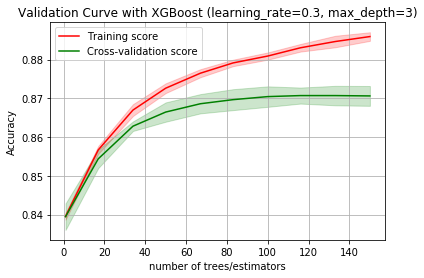

Best cross-validation result (0.87) obtained for 116 trees


In [78]:
### n_estimators
# https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

default_params = {
    'objective': 'binary:logistic', # 'multi:softmax' if not binary
    'max_depth': 3,
    'learning_rate': 0.3
}
n_estimators_range = np.linspace(1, 150, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
#     XGBClassifier('objective'='multi:softmax', random_state=my_random_state),
    x_train, y_train,
    param_name = 'n_estimators',
    param_range = n_estimators_range,
    cv=5,
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# fig = plt.figure(figsize=(10, 6), dpi=100)
plt.figure()
plt.title("Validation Curve with XGBoost (learning_rate=0.3, max_depth=3)")
plt.xlabel("number of trees/estimators")
plt.ylabel("Accuracy")
# plt.ylim(0.7, 1.05)

plt.plot(n_estimators_range, train_scores_mean, label="Training score", color="r")
plt.plot(n_estimators_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(n_estimators_range,train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.fill_between(n_estimators_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

# plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.grid()
plt.savefig('figures/xgboost_validation_curve_nestimators.png')
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for {1} trees".format(test_scores_mean[i], n_estimators_range[i]))

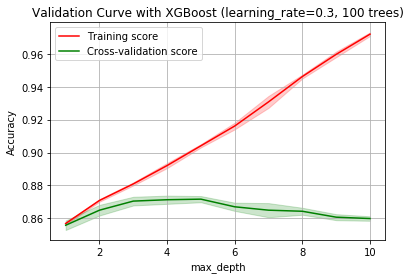

Best cross-validation result (0.87) obtained for max_depth=5


In [103]:
### max_depth
# https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/

default_params = {
    'objective': 'binary:logistic',# 'multi:softmax' if not binary
    'n_estimators': 100,
    'learning_rate': 0.3
}

maxdepth_range = np.linspace(1, 10, 10).astype('int')

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    x_train, y_train,
    param_name = 'max_depth',
    param_range = maxdepth_range,
    cv=5,
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# fig = plt.figure(figsize=(10, 6), dpi=100)
plt.figure()
plt.title("Validation Curve with XGBoost (learning_rate=0.3, 100 trees)")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
# plt.ylim(0.7, 1.05)

plt.plot(maxdepth_range, train_scores_mean, label="Training score", color="r")
plt.plot(maxdepth_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(maxdepth_range,train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.fill_between(maxdepth_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

# plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.grid()
plt.savefig('figures/xgboost_validation_curve_maxdepth.png')
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for max_depth={1}".format(test_scores_mean[i], maxdepth_range[i]))

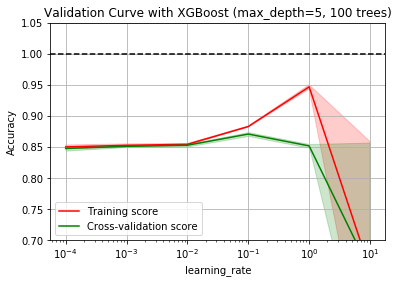

Best cross-validation result (0.87) obtained for learning_rate=0.1


In [82]:
### learning_rate
# https://kehuiyao.github.io/2019/03/21/xgboost-tuning-parameters/

default_params = {
    'objective': 'binary:logistic',# 'multi:softmax' if not binary
    'n_estimators': 100,
    'max_depth': 5
}

# learningrate_range = np.linspace(1, 10, 10).astype('int')
learningrate_range = np.logspace(-4, 1, 6)

train_scores, test_scores = validation_curve(
    XGBClassifier(**default_params),
    x_train, y_train,
    param_name = 'learning_rate',
    param_range = learningrate_range,
    cv=5,
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# fig = plt.figure(figsize=(10, 6), dpi=100)
plt.figure()
plt.title("Validation Curve with XGBoost (max_depth=5, 100 trees)")
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1.05)

plt.semilogx(learningrate_range, train_scores_mean, label="Training score", color="r")
plt.semilogx(learningrate_range, test_scores_mean, label="Cross-validation score", color="g")
plt.fill_between(learningrate_range,train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.fill_between(learningrate_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="g")

plt.axhline(y=1, color='k', ls='dashed')

plt.legend(loc="best")
plt.grid()
plt.savefig('figures/xgboost_validation_curve_learningrate.png')
plt.show()

i = np.argmax(test_scores_mean)
print("Best cross-validation result ({0:.2f}) obtained for learning_rate={1}".format(test_scores_mean[i], learningrate_range[i]))

## 3.2 hyperparameter tuning

In [83]:
param_test1 = {
 'max_depth':np.linspace(1, 10, 10).astype('int'),
 'learning_rate':np.logspace(-4, 1, 6),
 'n_estimators':np.linspace(1, 150, 10).astype('int')
}

default_params = {
    'objective': 'binary:logistic'# 'multi:softmax' if not binary
}
grid_xgb = GridSearchCV(estimator = XGBClassifier(**default_params),
 param_grid = param_test1,  cv=5)

tic = time.perf_counter_ns() 
grid_xgb.fit(x_train,y_train)
toc = time.perf_counter_ns() 
train_time[2] = toc-tic
print(f"training time {toc - tic} nanoseconds")
print()

print("best parameters & score from GridSearchCV: ")
print(grid_xgb.best_params_)
print(grid_xgb.best_score_)
print()

# training time 906549632800 nanoseconds

# best parameters & score from GridSearchCV: 
# {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
# 0.8718409915109403

training time 906549632800 nanoseconds

best parameters & score from GridSearchCV: 
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
0.8718409915109403



## 3.3 learning curve (takes a long time to run)

learning curve time 27967.4849 seconds



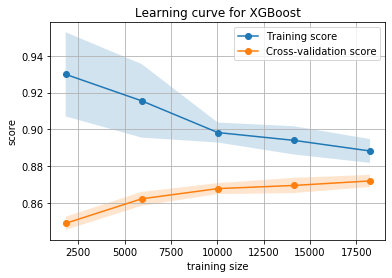

In [91]:
trainsizes = np.linspace(0.1, 1.0, 5)

tic = time.perf_counter() 
train_sizes, train_scores, test_scores = learning_curve(grid_xgb, x_train, y_train, train_sizes=trainsizes, 
                                                        random_state=my_random_state, cv=5)
toc = time.perf_counter() 
learningcurve_time[2] = toc-tic
print(f"learning curve time {toc - tic:0.4f} seconds") #~40min
print()

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_avg, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_avg, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std, alpha=0.2)

plt.title('Learning curve for XGBoost')
plt.xlabel('training size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/xgboost_learning_curve.png') 
plt.show()

## 3.4 prediction & confusion matrix

testing time 20158500 nanoseconds

Prediction accuracy on test set: 
0.8766506295424301
Prediction accuracy on train set: 
0.8867146367146367


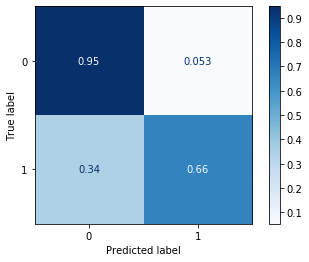

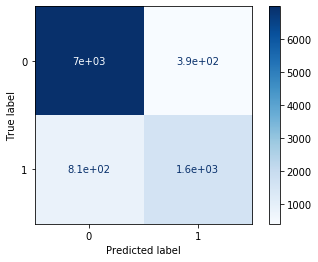

In [84]:

tic = time.perf_counter_ns() 
y_test_xgb = grid_xgb.predict(x_test)
toc = time.perf_counter_ns() 
test_time[2] = toc-tic
print(f"testing time {toc - tic} nanoseconds")
print()
print("Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_xgb))
best_test_accuracy[2] = accuracy_score(y_test,y_test_xgb)

y_train_xgb = grid_xgb.predict(x_train)
print("Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_xgb))
best_train_accuracy[2] = accuracy_score(y_train,y_train_xgb)



# testing time 20158500 nanoseconds

# Prediction accuracy on test set: 
# 0.8766506295424301
# Prediction accuracy on train set: 
# 0.8867146367146367

plot_confusion_matrix(grid_xgb, x_test, y_test,normalize='true',cmap=plt.cm.Blues)
plt.savefig('figures/xgboost_confusion_matrix_normalized.png') 
plt.show()

plot_confusion_matrix(grid_xgb, x_test, y_test,cmap=plt.cm.Blues)
plt.savefig('figures/xgboost_confusion_matrix.png') 
plt.show()

In [85]:
train_time,learningcurve_time ,test_time ,best_test_accuracy , best_train_accuracy

(array([4.95792020e+09, 5.63516328e+11, 9.06549633e+11, 6.63024046e+11,
        6.29676113e+10]),
 array([  55.3735978, 9772.1823865,    0.       , 4383.0980216,
         617.4818465]),
 array([1.8683000e+06, 1.6846400e+07, 2.0158500e+07, 1.6314321e+09,
        2.7286820e+08]),
 array([0.85443751, 0.79670386, 0.87665063, 0.84962637, 0.78994779]),
 array([0.85788873, 0.7969463 , 0.88671464, 0.85692348, 0.83042296]))

# 4. Support Vector Machines

In [52]:
#  normalize data
scaler = StandardScaler()
scaler.fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

###
# svc = svm.LinearSVC(random_state=my_random_state)
svc = svm.SVC(random_state=my_random_state)

In [53]:
svc.fit(x_train_std, y_train)

y_train_svc = svc.predict(x_train_std)
print(accuracy_score(y_train, y_train_svc))
y_test_svc = svc.predict(x_test_std)
print(accuracy_score(y_test, y_test_svc))
## default settings
#0.8569234819234819
# 0.8496263691268298

0.8569234819234819
0.8496263691268298


## 4.1 validation curve

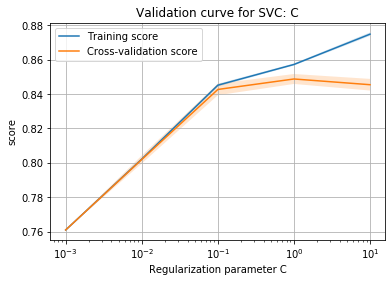

In [54]:
# Regularization parameter C
C_range = np.logspace(-3, 1, 5)
train_scores, test_scores = validation_curve(svc, x_train_std, y_train, param_name="C", param_range=C_range, cv=5)

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.semilogx(C_range, train_scores_avg, label='Training score')
plt.semilogx(C_range, test_scores_avg, label='Cross-validation score')
plt.fill_between(C_range, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(C_range, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for SVC: C')
plt.xlabel('Regularization parameter C')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/svc_validation_curve_C.png')
plt.show()

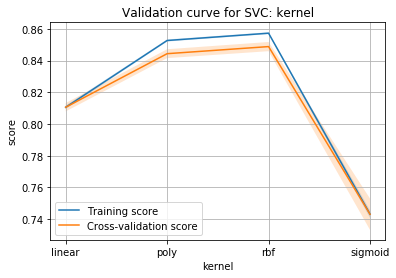

In [55]:
# kernel
kernel_range = ['linear','poly','rbf','sigmoid']
train_scores, test_scores = validation_curve(svc, x_train_std, y_train, param_name="kernel", param_range=kernel_range, cv=5)

xaxis = np.array([1,2,3,4])

plt.figure()
plt.xticks(xaxis, kernel_range)
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(xaxis, train_scores_avg, label='Training score')
plt.plot(xaxis, test_scores_avg, label='Cross-validation score')
plt.fill_between(xaxis, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(xaxis, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for SVC: kernel')
plt.xlabel('kernel')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/svc_validation_curve_kernel.png')
plt.show()

## 4.2 hyperparameter tuning

In [56]:
parameters = {'C':C_range, 'kernel': kernel_range}
grid_svc = GridSearchCV(svc, parameters)

tic = time.perf_counter_ns() 
grid_svc.fit(x_train_std, y_train)
toc = time.perf_counter_ns() 
train_time[3] = toc-tic
print(f"training time {toc - tic} nanoseconds")
print()

print("best parameters & score from GridSearchCV: ")
print(grid_svc.best_params_)
print(grid_svc.best_score_)
print()

#training time 663024045700 nanoseconds

# best parameters & score from GridSearchCV: 
# {'C': 1.0, 'kernel': 'rbf'}
# 0.848806833827384

training time 663024045700 nanoseconds

best parameters & score from GridSearchCV: 
{'C': 1.0, 'kernel': 'rbf'}
0.848806833827384



## 4.3 learning curve 

learning curve time 4383.0980 seconds



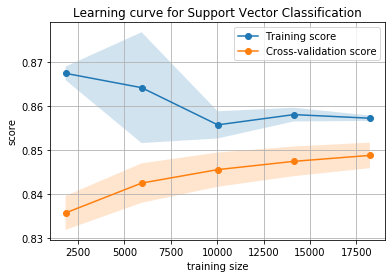

In [57]:
trainsizes = np.linspace(0.1, 1.0, 5)
tic = time.perf_counter() 
train_sizes, train_scores, test_scores = learning_curve(grid_svc, x_train_std, y_train, train_sizes=trainsizes, 
                                                        random_state=my_random_state, cv=5)
toc = time.perf_counter() 
learningcurve_time[3] = toc-tic
print(f"learning curve time {toc - tic:0.4f} seconds") 
print()


plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_avg, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_avg, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std, alpha=0.2)

plt.title('Learning curve for Support Vector Classification')
plt.xlabel('training size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/svc_learning_curve.png') 
plt.show()

#learning curve time 4383.0980 seconds

## 4.4 prediction & confusion matrix

testing time 1631432100 nanoseconds

Prediction accuracy on test set: 
0.8496263691268298
Prediction accuracy on train set: 
0.8569234819234819


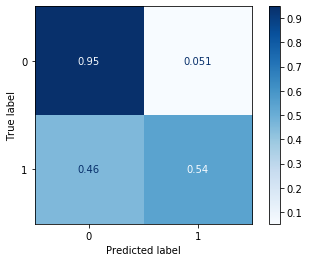

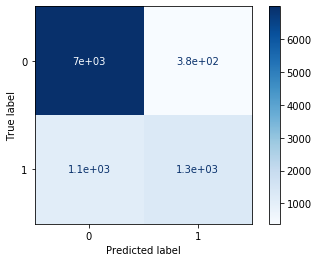

In [58]:

tic = time.perf_counter_ns() 
y_test_svc = grid_svc.predict(x_test_std)
toc = time.perf_counter_ns() 
test_time[3] = toc-tic
print(f"testing time {toc - tic} nanoseconds")
print()
print("Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_svc))
best_test_accuracy[3] = accuracy_score(y_test,y_test_svc)

y_train_svc = grid_svc.predict(x_train_std)
print("Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_svc))
best_train_accuracy[3] = accuracy_score(y_train,y_train_svc)


# testing time 1631432100 nanoseconds

# Prediction accuracy on test set: 
# 0.8496263691268298
# Prediction accuracy on train set: 
# 0.8569234819234819



plot_confusion_matrix(grid_svc, x_test_std, y_test,normalize='true',cmap=plt.cm.Blues)
plt.savefig('figures/svc_confusion_matrix_normalized.png') 
plt.show()

plot_confusion_matrix(grid_svc, x_test_std, y_test,cmap=plt.cm.Blues)
plt.savefig('figures/svc_confusion_matrix.png') 
plt.show()

In [59]:
train_time,learningcurve_time ,test_time ,best_test_accuracy , best_train_accuracy

(array([4.95792020e+09, 5.63516328e+11, 0.00000000e+00, 6.63024046e+11,
        0.00000000e+00]),
 array([  55.3735978, 9772.1823865,    0.       , 4383.0980216,
           0.       ]),
 array([1.8683000e+06, 1.6846400e+07, 0.0000000e+00, 1.6314321e+09,
        0.0000000e+00]),
 array([0.85443751, 0.79670386, 0.        , 0.84962637, 0.        ]),
 array([0.85788873, 0.7969463 , 0.        , 0.85692348, 0.        ]))

# 5. k-Nearest Neighbors

In [60]:
knn = KNeighborsClassifier() # default n_neighbor=5, p=2 # No random_state

In [61]:
knn.fit(x_train, y_train)

y_train_knn = knn.predict(x_train)
print(accuracy_score(y_train, y_train_knn))
y_test_knn = knn.predict(x_test)
print(accuracy_score(y_test, y_test_knn))
## default settings
# 0.8428834678834679
# 0.7736718190193469

0.8428834678834679
0.7736718190193469


## 4.1 validation curve

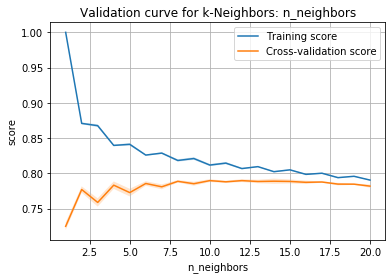

Best cross-validation result (0.7897) obtained for n_neighbors=12


In [107]:
# n_neighbors
nneighbors_range = np.arange(20)+1
train_scores, test_scores = validation_curve(knn, x_train, y_train, param_name="n_neighbors", param_range=nneighbors_range, cv=5)

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(nneighbors_range, train_scores_avg, label='Training score')
plt.plot(nneighbors_range, test_scores_avg, label='Cross-validation score')
plt.fill_between(nneighbors_range, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(nneighbors_range, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for k-Neighbors: n_neighbors')
plt.xlabel('n_neighbors')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/knn_validation_curve_n_neighbors.png')
plt.show()

i = np.argmax(test_scores_avg)
print("Best cross-validation result ({0:.4f}) obtained for n_neighbors={1}".format(test_scores_avg[i], nneighbors_range[i]))

# Best cross-validation result (0.7897) obtained for n_neighbors=10

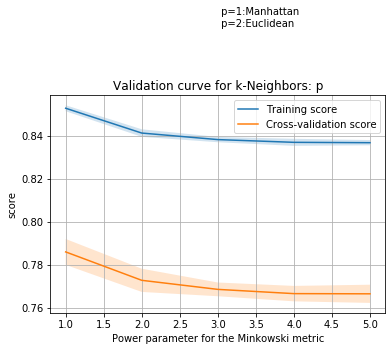

Best cross-validation result (0.7859) obtained for p=1


In [63]:
# Power parameter for the Minkowski metric
p_range = np.arange(5)+1
train_scores, test_scores = validation_curve(knn, x_train, y_train, param_name="p", param_range=p_range, cv=5)

plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(p_range, train_scores_avg, label='Training score')
plt.plot(p_range, test_scores_avg, label='Cross-validation score')
plt.fill_between(p_range, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(p_range, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std,  alpha=0.2)

plt.title('Validation curve for k-Neighbors: p')
plt.xlabel('Power parameter for the Minkowski metric')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.text(3, 0.9, " p=1:Manhattan\n p=2:Euclidean",verticalalignment='top')
plt.savefig('figures/knn_validation_curve_p.png')
plt.show()


i = np.argmax(test_scores_avg)
print("Best cross-validation result ({0:.4f}) obtained for p={1}".format(test_scores_avg[i], p_range[i]))

# Best cross-validation result (0.7859) obtained for p=1

## 4.2 hyperparameter tuning

In [64]:
parameters = {'n_neighbors':nneighbors_range, 'p': p_range}
grid_knn = GridSearchCV(knn, parameters)

tic = time.perf_counter_ns() 
grid_knn.fit(x_train, y_train)
toc = time.perf_counter_ns() 
train_time[4] = toc-tic
print(f"training time {toc - tic:0.4f} nanoseconds")
print()

print("best parameters & score from GridSearchCV: ")
print(grid_knn.best_params_)
print(grid_knn.best_score_)
print()

# training time 62967611300.0000 nanoseconds

# best parameters & score from GridSearchCV: 
# {'n_neighbors': 8, 'p': 1}
# 0.7974727527851162

training time 62967611300.0000 nanoseconds

best parameters & score from GridSearchCV: 
{'n_neighbors': 8, 'p': 1}
0.7974727527851162



## 4.3 learning curve 

learning curve time 617.4818 seconds



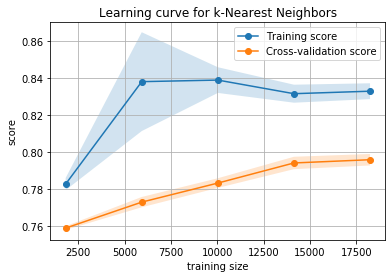

In [65]:
trainsizes = np.linspace(0.1, 1.0, 5)
tic = time.perf_counter() 
train_sizes, train_scores, test_scores = learning_curve(grid_knn, x_train, y_train, train_sizes=trainsizes, 
                                                        random_state=my_random_state, cv=5)
toc = time.perf_counter() 
learningcurve_time[4] = toc-tic
print(f"learning curve time {toc - tic:0.4f} seconds") 
print()


plt.figure()
train_scores_avg = np.mean(train_scores, axis=1)
test_scores_avg = np.mean(test_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.plot(train_sizes, train_scores_avg, 'o-', label='Training score')
plt.plot(train_sizes, test_scores_avg, 'o-', label='Cross-validation score')
plt.fill_between(train_sizes, train_scores_avg - train_scores_std, train_scores_avg + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, test_scores_avg - test_scores_std, test_scores_avg + test_scores_std, alpha=0.2)

plt.title('Learning curve for k-Nearest Neighbors')
plt.xlabel('training size')
plt.ylabel("score")
plt.legend(loc="best")
plt.grid()
plt.savefig('figures/knn_learning_curve.png') 
plt.show()

#learning curve time 617.4818 seconds


## 4.4 prediction & confusion matrix

testing time 272868200 nanoseconds

Prediction accuracy on test set: 
0.7899477940423789
Prediction accuracy on train set: 
0.8304229554229554


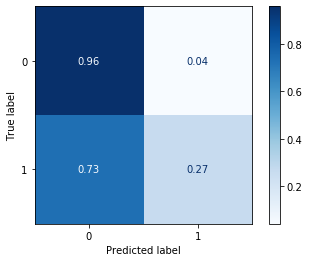

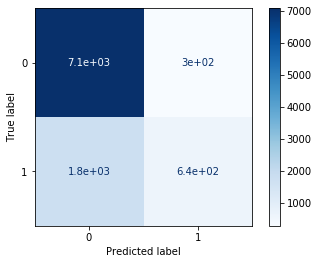

In [66]:

tic = time.perf_counter_ns() 
y_test_knn = grid_knn.predict(x_test)
toc = time.perf_counter_ns() 
test_time[4] = toc-tic
print(f"testing time {toc - tic} nanoseconds")
print()
print("Prediction accuracy on test set: ")
print(accuracy_score(y_test,y_test_knn))
best_test_accuracy[4] = accuracy_score(y_test,y_test_knn)

y_train_knn = grid_knn.predict(x_train)
print("Prediction accuracy on train set: ")
print(accuracy_score(y_train,y_train_knn))
best_train_accuracy[4] = accuracy_score(y_train,y_train_knn)

# Prediction accuracy on test set: 
# 0.9405940594059405

plot_confusion_matrix(grid_knn, x_test, y_test,normalize='true',cmap=plt.cm.Blues)
plt.savefig('figures/knn_confusion_matrix_normalized.png') 
plt.show()

plot_confusion_matrix(grid_knn, x_test, y_test,cmap=plt.cm.Blues)
plt.savefig('figures/knn_confusion_matrix.png') 
plt.show()

#testing time 272868200 nanoseconds

# Prediction accuracy on test set: 
# 0.7899477940423789
# Prediction accuracy on train set: 
# 0.8304229554229554

# 5. Comparing Classification Algorithms

In [93]:
train_time,learningcurve_time ,test_time ,best_test_accuracy , best_train_accuracy

(array([4.95792020e+09, 5.63516328e+11, 9.06549633e+11, 6.63024046e+11,
        6.29676113e+10]),
 array([   55.3735978,  9772.1823865, 27967.4849448,  4383.0980216,
          617.4818465]),
 array([1.8683000e+06, 1.6846400e+07, 2.0158500e+07, 1.6314321e+09,
        2.7286820e+08]),
 array([0.85443751, 0.79670386, 0.87665063, 0.84962637, 0.78994779]),
 array([0.85788873, 0.7969463 , 0.88671464, 0.85692348, 0.83042296]))

In [105]:

classifiers = ['Decision tree', 'Neural network', 'XGBoost', 'SVM', 'kNN']
x = np.arange(len(classifiers))

num_classifiers

5

## Accuracy

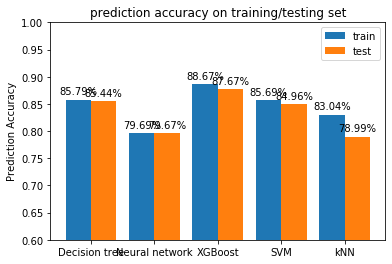

In [106]:
#### https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html

width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, best_train_accuracy, width, label='train')
rects2 = ax.bar(x + width/2, best_test_accuracy, width, label='test')

plt.gca().set_ylim(0.6, 1.0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Prediction Accuracy')
ax.set_title('prediction accuracy on training/testing set')
ax.set_xticks(x)
ax.set_xticklabels(classifiers)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:0.2f}%'.format(height*100),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

# fig.tight_layout()
plt.savefig('figures/accuracy.png') 

plt.show()

## Time

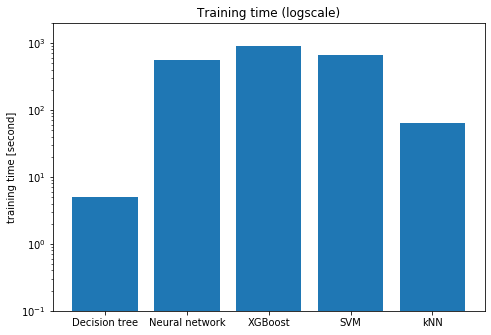

In [108]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(classifiers,train_time/1e9)

plt.ylim(.1, 2000)
plt.title('Training time (logscale)')
ax.set_yscale('log')
# plt.xlabel('classifiers')
plt.ylabel("training time [second]")
# plt.savefig('figures/training_time.png') 
plt.show()


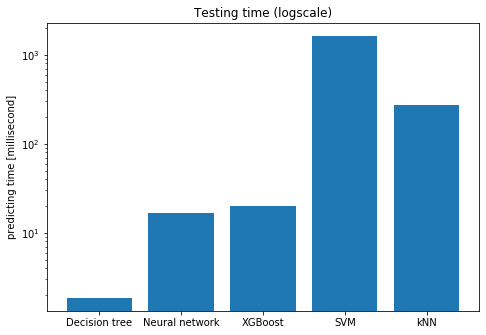

In [90]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(classifiers,test_time/1e6)

plt.title('Testing time (logscale)')
ax.set_yscale('log')

plt.ylabel("predicting time [millisecond]")
# plt.savefig('figures/test_time.png') 
plt.show()

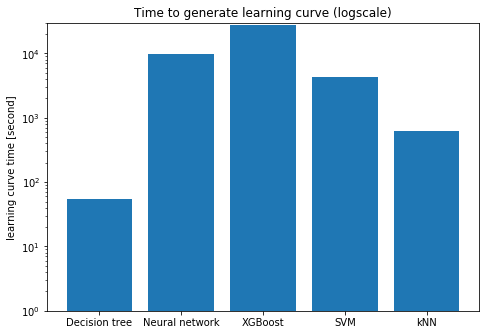

In [99]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(classifiers,learningcurve_time )

plt.ylim(1, 30000)
plt.title('Time to generate learning curve (logscale)')
ax.set_yscale('log')
plt.ylabel("learning curve time [second]")
# plt.savefig('figures/learningcurve_time.png') 
plt.show()